In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.9 MB/s eta 0:00:00


In [3]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import lightgbm as lgb
import catboost as ctb
from catboost import *
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn import linear_model
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, cross_val_score
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer

In [5]:
class CFG:
  ver=79
  ver_pred=72
  model="lightgbm"
  n_folds=8
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7]
  seed=42
  boosting_type="gbdt"

In [6]:
train = pd.read_csv(os.path.join(OUTPUT_DIR, f'OOF_LGBM&CTB_seed{CFG.seed}_ver{CFG.ver_pred}.csv'))
test = pd.read_csv(os.path.join(OUTPUT_DIR, f'test_pred_LGBM&CTB_seed{CFG.seed}_ver{CFG.ver_pred}.csv'))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(11775, 3848)


,Unnamed: 0,id,lat,lon,area,YMD,year,month,cover,depth_original,...,second,Landsat_time,year-month,main_pred,sea_pred,landsat_pred,last_year_landsat_pred,lgbm_pred,cat_pred,pred
0,0,793,27.002698,127.923027,40.0,2009.10.1-2009.11.10,2009.0,12.0,0.80,NaN,...,46.0,2009-12-12 06:01:46,2009-12-01,NaN,NaN,NaN,NaN,0.180303,0.180303,0.180303
1,1,794,24.708444,125.318694,20.0,20110923,2012.0,1.0,0.05,NaN,...,2.0,2012-01-01 05:14:02,2012-01-01,NaN,NaN,NaN,NaN,0.180303,0.180303,0.180303
2,2,795,24.360389,123.987611,20.0,20100812,2010.0,8.0,0.05,NaN,...,6.0,2010-08-08 00:38:06,2010-08-01,NaN,NaN,NaN,NaN,0.180303,0.180303,0.180303


(4039, 3833)


,Unnamed: 0,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,...,knn_lastyear_feature56,knn_lastyear_feature108,knn_lastyear_feature74,main_pred,sea_pred,landsat_pred,last_year_landsat_pred,pred_lgbm,pred_cat,pred
0,0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,...,0.0,0.0,0.0,0.030816,-0.010784,0.188975,0.278140,0.105388,0.079942,0.092665
1,1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,...,0.0,0.0,0.0,0.099350,0.047481,0.055999,0.088488,0.081975,0.066146,0.074060
2,2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,...,0.0,0.0,0.0,0.455490,0.075310,0.124247,0.031221,0.054687,0.067749,0.061218


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [7]:
oof_features = ["main_pred","sea_pred","landsat_pred","last_year_landsat_pred"]
target = "cover"

In [8]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [9]:
def sort_yearmonth(df):
  df['year-month'] = df.year.astype(int).astype(str) + '-' + df.month.astype(int).astype(str)
  df['year-month'] = pd.to_datetime(df['year-month'], format='%Y-%m')
  df = df.sort_values("year-month").reset_index(drop=True)
  return df

In [10]:
lgbm_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'boosting': "gbdt",
        'seed': 42,
        "reg_alpha":0.1,
        #'reg_lambda': 0.5,
        "n_estimators":3000,
        'min_child_weight': 1,
        'colsample_bytree': 0.4
    }

def get_oof_LGBM_pred(df, test, oof_features):
  oof_df = pd.DataFrame()
  test_preds = np.zeros((len(test), 15))
  lgbm_params["n_estimators"] = 5000

  cv = TimeSeriesSplit(n_splits=15)

  for fold, (tr_index, va_index) in enumerate(cv.split(df)):
    print("="*15,f" OUTER CV FOLD {fold} ","="*15)
    train_folds = df.iloc[tr_index]
    valid_folds = df.iloc[va_index]


    print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
    print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


    train_X = train_folds[oof_features].values
    valid_X = valid_folds[oof_features].values
    test_X = test[oof_features].values
    train_labels = train_folds[target].values
    valid_labels = valid_folds[target].values

    clf = lgb.LGBMRegressor(**lgbm_params)
    clf.fit(train_X, train_labels,
            eval_set=[(valid_X, valid_labels)],
            verbose = 1000,
            early_stopping_rounds=50)
      
    valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
    test_preds[:, fold] = clf.predict(test_X)
    oof_df = pd.concat([oof_df, valid_folds])


    get_score(valid_labels, valid_folds["lgbm_pred"])

  get_score(oof_df[target], oof_df[f"lgbm_pred"])
  return oof_df,  test_preds


cat_params = {
        "loss_function":"RMSE",
        "n_estimators":6000,
        "random_seed":2022,
        "learning_rate":0.05
  }

def get_oof_Cat_pred(df, test, oof_features):
  oof_df = pd.DataFrame()
  test_preds = np.zeros((len(test), 15))

  cv = TimeSeriesSplit(n_splits=15)

  for fold, (tr_index, va_index) in enumerate(cv.split(df)):
    print("="*15,f" OUTER CV FOLD {fold} ","="*15)
    train_folds = df.iloc[tr_index]
    valid_folds = df.iloc[va_index]


    print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
    print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


    train_X = train_folds[oof_features].values
    valid_X = valid_folds[oof_features].values
    test_X = test[oof_features].values
    train_labels = train_folds[target].values
    valid_labels = valid_folds[target].values

    #clf = model
    clf = ctb.CatBoostRegressor(**cat_params,
                                    #task_type='GPU'
                                    )
    clf.fit(train_X, train_labels,
              eval_set=[(train_X,train_labels),(valid_X, valid_labels)],
              verbose = 200,
              early_stopping_rounds = 50,
              #cat_features=categorical_features,
              use_best_model=True
          )
      
    valid_folds[f"cat_pred"] = clf.predict(valid_X)
    test_preds[:, fold] = clf.predict(test_X)
    oof_df = pd.concat([oof_df, valid_folds])


    get_score(valid_labels, valid_folds["cat_pred"])

  get_score(oof_df[target], oof_df[f"cat_pred"])
  return oof_df,  test_preds


def get_oof_linear_pred(df, test, model, oof_features, model_name=""):
  oof_df = pd.DataFrame()
  test_preds = np.zeros((len(test), 15))

  cv = TimeSeriesSplit(n_splits=15)

  for fold, (tr_index, va_index) in enumerate(cv.split(df)):
    print("="*15,f" OUTER CV FOLD {fold} ","="*15)
    train_folds = df.iloc[tr_index]
    valid_folds = df.iloc[va_index]


    print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
    print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


    train_X = train_folds[oof_features].values
    valid_X = valid_folds[oof_features].values
    test_X = test[oof_features].values
    train_labels = train_folds[target].values
    valid_labels = valid_folds[target].values

    clf = model
    clf.fit(train_X, train_labels)
      
    valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
    test_preds[:, fold] = clf.predict(test_X)
    oof_df = pd.concat([oof_df, valid_folds])


    get_score(valid_labels, valid_folds[f"{model_name}_pred"])

  get_score(oof_df[target], oof_df[f"{model_name}_pred"])
  return oof_df,  test_preds

In [11]:
oof_train = sort_yearmonth(train)
oof_features = ["main_pred","sea_pred","landsat_pred","last_year_landsat_pred"]

oof_train = oof_train.dropna(subset=["main_pred","sea_pred","landsat_pred","last_year_landsat_pred"]).reset_index(drop=True)

get_score(oof_train["cover"], oof_train["main_pred"])
get_score(oof_train["cover"], oof_train["sea_pred"])
get_score(oof_train["cover"], oof_train["landsat_pred"])
get_score(oof_train["cover"], oof_train["last_year_landsat_pred"])

RMSE 0.1584668043938505
RMSE 0.13619718736240996
RMSE 0.16695010570048058
RMSE 0.18042071617931904


In [12]:
svr = svm.LinearSVR(random_state=CFG.seed, tol=1e-5)
linear = linear_model.LinearRegression()
ridge = linear_model.Ridge(alpha=1)

#oof_svr, preds_svr = get_oof_linear_pred(oof_train, test, svr, oof_features, "svr")
#oof_linear, preds_linear = get_oof_linear_pred(oof_train, test, linear, oof_features, "linear")
#oof_ridge, preds_ridge = get_oof_linear_pred(oof_train, test, ridge, oof_features, "ridge")

In [13]:
oof_lgbm, preds_lgbm = get_oof_LGBM_pred(oof_train, test, oof_features)
oof_cat, preds_cat = get_oof_Cat_pred(oof_train, test, oof_features)

===============  OUTER CV FOLD 0  ===============
train period : 1999.0年8.0月 ～ 2009.0年3.0月
valid period : 2009.0年3.0月 ～ 2009.0年8.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
RMSE 0.17386113267597625
===============  OUTER CV FOLD 1  ===============


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

train period : 1999.0年8.0月 ～ 2009.0年8.0月
valid period : 2009.0年8.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.10829140340683628
===============  OUTER CV FOLD 2  ===============
train period : 1999.0年8.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.0860134662784759
===============  OUTER CV FOLD 3  ===============
train period : 1999.0年8.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.09691435472605711
===============  OUTER CV FOLD 4  ===============
train period : 1999.0年8.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年10.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.09080733953410171
===============  OUTER CV FOLD 5  ===============
train period : 1999.0年8.0月 ～ 2010.0年10.0月
valid period : 2010.0年10.0月 ～ 2010.0年11.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.07997270253616649
===============  OUTER CV FOLD 6  ===============
train period : 1999.0年8.0月 ～ 2010.0年11.0月
valid period : 2010.0年11.0月 ～ 2011.0年4.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argum

RMSE 0.11041417917749452
===============  OUTER CV FOLD 7  ===============
train period : 1999.0年8.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年8.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argum

RMSE 0.07645297348103501
===============  OUTER CV FOLD 8  ===============
train period : 1999.0年8.0月 ～ 2011.0年8.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argum

RMSE 0.07417169737218414
===============  OUTER CV FOLD 9  ===============
train period : 1999.0年8.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2012.0年1.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.08000493048205837
===============  OUTER CV FOLD 10  ===============
train period : 1999.0年8.0月 ～ 2012.0年1.0月
valid period : 2012.0年1.0月 ～ 2019.0年8.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.15066789269656372
===============  OUTER CV FOLD 11  ===============
train period : 1999.0年8.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.15535495842373728
===============  OUTER CV FOLD 12  ===============
train period : 1999.0年8.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.17509888345458227
===============  OUTER CV FOLD 13  ===============
train period : 1999.0年8.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.1861275635850826
===============  OUTER CV FOLD 14  ===============
train period : 1999.0年8.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年12.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.20482972435571287
RMSE 0.13100124572026164
===============  OUTER CV FOLD 0  ===============
train period : 1999.0年8.0月 ～ 2009.0年3.0月
valid period : 2009.0年3.0月 ～ 2009.0年8.0月
0:	learn: 0.3088864	test: 0.3088864	test1: 0.3041140	best: 0.3041140 (0)	total: 48.6ms	remaining: 4m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1610599676
bestIteration = 114

Shrink model to first 115 iterations.
RMSE 0.1610599677874468
===============  OUTER CV FOLD 1  ===============
train period : 1999.0年8.0月 ～ 2009.0年8.0月
valid period : 2009.0年8.0月 ～ 2009.0年12.0月
0:	learn: 0.3034354	test: 0.3034354	test1: 0.3754690	best: 0.3754690 (0)	total: 1.27ms	remaining: 7.61s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


200:	learn: 0.1443475	test: 0.1443475	test1: 0.1077530	best: 0.1075070 (181)	total: 242ms	remaining: 6.97s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1075069705
bestIteration = 181

Shrink model to first 182 iterations.
RMSE 0.10750697074772567
===============  OUTER CV FOLD 2  ===============
train period : 1999.0年8.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2009.0年12.0月
0:	learn: 0.3112935	test: 0.3112935	test1: 0.2976881	best: 0.2976881 (0)	total: 1.47ms	remaining: 8.81s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.08394012669
bestIteration = 94

Shrink model to first 95 iterations.
RMSE 0.08394012705126404
===============  OUTER CV FOLD 3  ===============
train period : 1999.0年8.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
0:	learn: 0.3034966	test: 0.3034966	test1: 0.2567393	best: 0.2567393 (0)	total: 1.57ms	remaining: 9.41s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09234819089
bestIteration = 111

Shrink model to first 112 iterations.
RMSE 0.09234819153321759
===============  OUTER CV FOLD 4  ===============
train period : 1999.0年8.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年10.0月
0:	learn: 0.2932408	test: 0.2932408	test1: 0.1996848	best: 0.1996848 (0)	total: 2.08ms	remaining: 12.5s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.08221662445
bestIteration = 69

Shrink model to first 70 iterations.
RMSE 0.08221662629009904
===============  OUTER CV FOLD 5  ===============
train period : 1999.0年8.0月 ～ 2010.0年10.0月
valid period : 2010.0年10.0月 ～ 2010.0年11.0月
0:	learn: 0.2782502	test: 0.2782502	test1: 0.1705561	best: 0.1705561 (0)	total: 2.11ms	remaining: 12.7s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07742124044
bestIteration = 66

Shrink model to first 67 iterations.
RMSE 0.07742124156085481
===============  OUTER CV FOLD 6  ===============
train period : 1999.0年8.0月 ～ 2010.0年11.0月
valid period : 2010.0年11.0月 ～ 2011.0年4.0月
0:	learn: 0.2648267	test: 0.2648267	test1: 0.1766662	best: 0.1766662 (0)	total: 1.96ms	remaining: 11.8s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1086751552
bestIteration = 81

Shrink model to first 82 iterations.
RMSE 0.10867515685067557
===============  OUTER CV FOLD 7  ===============
train period : 1999.0年8.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年8.0月
0:	learn: 0.2552498	test: 0.2552498	test1: 0.1403696	best: 0.1403696 (0)	total: 1.89ms	remaining: 11.3s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


200:	learn: 0.1060931	test: 0.1060931	test1: 0.0730854	best: 0.0729759 (169)	total: 360ms	remaining: 10.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07297591222
bestIteration = 169

Shrink model to first 170 iterations.
RMSE 0.07297591309683042
===============  OUTER CV FOLD 8  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 1999.0年8.0月 ～ 2011.0年8.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
0:	learn: 0.2449826	test: 0.2449826	test1: 0.1286544	best: 0.1286544 (0)	total: 2.45ms	remaining: 14.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07690652682
bestIteration = 48

Shrink model to first 49 iterations.
RMSE 0.07690652706635696
===============  OUTER CV FOLD 9  ===============
train period : 1999.0年8.0月 ～ 2011.0年10.0月


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


valid period : 2011.0年10.0月 ～ 2012.0年1.0月
0:	learn: 0.2356989	test: 0.2356989	test1: 0.1365721	best: 0.1365721 (0)	total: 1.98ms	remaining: 11.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07636770854
bestIteration = 103

Shrink model to first 104 iterations.
RMSE 0.07636770910285669
===============  OUTER CV FOLD 10  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 1999.0年8.0月 ～ 2012.0年1.0月
valid period : 2012.0年1.0月 ～ 2019.0年8.0月
0:	learn: 0.2283718	test: 0.2283718	test1: 0.2172632	best: 0.2172632 (0)	total: 2.18ms	remaining: 13.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1485144825
bestIteration = 67

Shrink model to first 68 iterations.
RMSE 0.14851448284363442
===============  OUTER CV FOLD 11  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 1999.0年8.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
0:	learn: 0.2273937	test: 0.2273937	test1: 0.2885011	best: 0.2885011 (0)	total: 2.39ms	remaining: 14.3s
200:	learn: 0.1027087	test: 0.1027087	test1: 0.1514531	best: 0.1513947 (191)	total: 464ms	remaining: 13.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1513457358
bestIteration = 325

Shrink model to first 326 iterations.
RMSE 0.15134573587716116
===============  OUTER CV FOLD 12  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 1999.0年8.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2326102	test: 0.2326102	test1: 0.2844784	best: 0.2844784 (0)	total: 2.47ms	remaining: 14.8s
200:	learn: 0.1060106	test: 0.1060106	test1: 0.1709217	best: 0.1703153 (153)	total: 500ms	remaining: 14.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1703153376
bestIteration = 153

Shrink model to first 154 iterations.
RMSE 0.17031533776415234
===============  OUTER CV FOLD 13  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 1999.0年8.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
0:	learn: 0.2366900	test: 0.2366900	test1: 0.2863219	best: 0.2863219 (0)	total: 3.9ms	remaining: 23.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1771268609
bestIteration = 148

Shrink model to first 149 iterations.
RMSE 0.17712686096799365
===============  OUTER CV FOLD 14  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 1999.0年8.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年12.0月
0:	learn: 0.2402238	test: 0.2402238	test1: 0.3919284	best: 0.3919284 (0)	total: 4.32ms	remaining: 25.9s
200:	learn: 0.1156153	test: 0.1156153	test1: 0.2021349	best: 0.2021182 (196)	total: 950ms	remaining: 27.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2021181927
bestIteration = 196

Shrink model to first 197 iterations.
RMSE 0.20211819322433916
RMSE 0.1267289282292382


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


In [14]:
cover_max = train.cover.max()
_oof = oof_lgbm.copy()
_oof.drop("cat_pred",axis=1,inplace=True)
_oof = _oof.merge(oof_cat[["id","cat_pred"]],how="left",on="id")
get_score(_oof["cover"], _oof["lgbm_pred"])
get_score(_oof["cover"], _oof["cat_pred"])
_oof["pred"] = (_oof["lgbm_pred"] + _oof["cat_pred"]) / 2
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.13100124572026164
RMSE 0.1267289282292382
RMSE 0.127662750776481


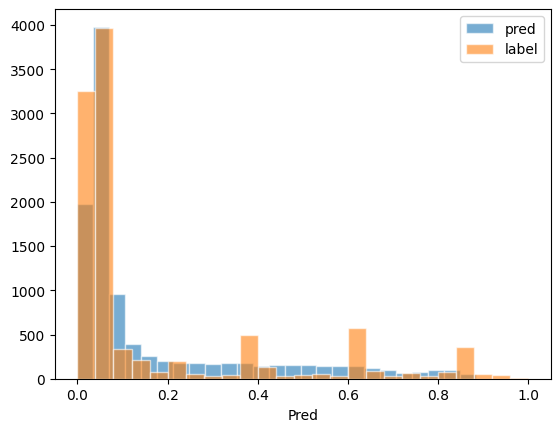

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [16]:
pred_df = test.copy()
pred_lgbm = np.mean(preds_lgbm, axis=1)
pred_cat = np.mean(preds_cat, axis=1)

pred = (pred_lgbm + pred_cat) / 2

pred_df["lgbm_pred"] = pred_lgbm
pred_df["cat_pred"] = pred_cat
pred_df["pred"] = pred

pred_df = pred_df.sort_index()
pred_df

,Unnamed: 0,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,...,knn_lastyear_feature74,main_pred,sea_pred,landsat_pred,last_year_landsat_pred,pred_lgbm,pred_cat,pred,lgbm_pred,cat_pred
0,0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,...,0.0,0.030816,-0.010784,0.188975,0.278140,0.105388,0.079942,0.053083,0.050385,0.055782
1,1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,...,0.0,0.099350,0.047481,0.055999,0.088488,0.081975,0.066146,0.061540,0.065936,0.057143
2,2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,...,0.0,0.455490,0.075310,0.124247,0.031221,0.054687,0.067749,0.135611,0.178579,0.092642
3,3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,...,0.0,0.039567,0.059341,0.051703,0.045531,0.059379,0.058592,0.041653,0.040443,0.042862
4,4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,...,0.0,0.232364,0.326314,0.481086,0.285849,0.361539,0.365227,0.376357,0.391534,0.361179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,...,0.0,0.255388,-0.022587,0.249109,0.245054,0.172376,0.100498,0.165759,0.217959,0.113559
4035,4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,...,0.0,0.139790,0.033583,0.052470,0.119710,0.057925,0.069628,0.063582,0.066081,0.061082
4036,4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,...,0.0,0.432453,0.041005,0.165249,0.295922,0.035847,0.092173,0.171880,0.210436,0.133324
4037,4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,...,0.0,0.189546,0.263860,0.161360,0.050390,0.118602,0.149491,0.171833,0.167595,0.176071


In [17]:
oof_all_cat = pd.read_csv(os.path.join(OUTPUT_DIR, f'OOF_CTB_seed42_ver78.csv'))
oof_all_lgb = pd.read_csv(os.path.join(OUTPUT_DIR, f'OOF_LGBM_seed42_ver77.csv'))

pred_all_cat = pd.read_csv(os.path.join(OUTPUT_DIR, f'test_pred_CTB_seed42_ver78.csv'))
pred_all_lgb = pd.read_csv(os.path.join(OUTPUT_DIR, f'test_pred_LGBM_seed42_ver77.csv'))

oof_all_cat.rename(columns={"pred":"all_cat_pred"},inplace=True)
oof_all_lgb.rename(columns={"pred":"all_lgb_pred"},inplace=True)
pred_all_cat.rename(columns={"pred":"all_cat_pred"},inplace=True)
pred_all_lgb.rename(columns={"pred":"all_lgb_pred"},inplace=True)

_oof = _oof.merge(oof_all_cat[["id","all_cat_pred"]],how="left",on="id").merge(oof_all_lgb[["id","all_lgb_pred"]],how="left",on="id")
pred_df = pred_df.merge(pred_all_cat[["id","all_cat_pred"]],how="left",on="id").merge(pred_all_lgb[["id","all_lgb_pred"]],how="left",on="id")

oof_df = sort_yearmonth(_oof)
features = ["lgbm_pred","cat_pred", "all_cat_pred", "all_lgb_pred"]
oof_df = oof_df.dropna(subset=["lgbm_pred","cat_pred", "all_cat_pred","all_lgb_pred"]).reset_index(drop=True)


pred_df = pred_df.sort_index()

<ipython-input-17-79bebd29c7bd>:1: DtypeWarning: Columns (5,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  oof_all_cat = pd.read_csv(os.path.join(OUTPUT_DIR, f'OOF_CTB_seed42_ver78.csv'))
<ipython-input-17-79bebd29c7bd>:2: DtypeWarning: Columns (5,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  oof_all_lgb = pd.read_csv(os.path.join(OUTPUT_DIR, f'OOF_LGBM_seed42_ver77.csv'))


In [18]:
oof_svr, preds_svr = get_oof_linear_pred(oof_df, pred_df, svr, features, "svr")
oof_linear, preds_linear = get_oof_linear_pred(oof_df, pred_df, linear, features, "linear")
oof_ridge, preds_ridge = get_oof_linear_pred(oof_df, pred_df, ridge, features, "ridge")
#oof_ctb, preds_ctb = get_oof_Cat_pred(oof_df, pred_df, features)

===============  OUTER CV FOLD 0  ===============
train period : 2009.0年3.0月 ～ 2009.0年8.0月
valid period : 2009.0年8.0月 ～ 2009.0年12.0月
RMSE 0.11541221870596363
===============  OUTER CV FOLD 1  ===============
train period : 2009.0年3.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2009.0年12.0月
RMSE 0.08861098124917312
===============  OUTER CV FOLD 2  ===============


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

train period : 2009.0年3.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
RMSE 0.08071412798723124
===============  OUTER CV FOLD 3  ===============
train period : 2009.0年3.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

RMSE 0.08591767975216193
===============  OUTER CV FOLD 4  ===============
train period : 2009.0年3.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年11.0月
RMSE 0.07943672997643175
===============  OUTER CV FOLD 5  ===============


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


train period : 2009.0年3.0月 ～ 2010.0年11.0月
valid period : 2010.0年11.0月 ～ 2011.0年3.0月
RMSE 0.10620943435709924
===============  OUTER CV FOLD 6  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2011.0年3.0月
valid period : 2011.0年3.0月 ～ 2011.0年6.0月
RMSE 0.08121437081020816
===============  OUTER CV FOLD 7  ===============


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2011.0年6.0月
valid period : 2011.0年6.0月 ～ 2011.0年9.0月
RMSE 0.06655637401543
===============  OUTER CV FOLD 8  ===============


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2012.0年1.0月
RMSE 0.08381838011788383
===============  OUTER CV FOLD 9  ===============


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2012.0年1.0月
valid period : 2012.0年1.0月 ～ 2019.0年7.0月
RMSE 0.07301005717159688

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)



===============  OUTER CV FOLD 10  ===============
train period : 2009.0年3.0月 ～ 2019.0年7.0月
valid period : 2019.0年7.0月 ～ 2019.0年9.0月


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


RMSE 0.1706092347378954
===============  OUTER CV FOLD 11  ===============
train period : 2009.0年3.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年9.0月


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


RMSE 0.16422431290878323
===============  OUTER CV FOLD 12  ===============
train period : 2009.0年3.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


RMSE 0.1553560554713765
===============  OUTER CV FOLD 13  ===============
train period : 2009.0年3.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


RMSE 0.17891991008520386
===============  OUTER CV FOLD 14  ===============
train period : 2009.0年3.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年12.0月


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


RMSE 0.20443927704754217
RMSE 0.12384427015612112
===============  OUTER CV FOLD 0  ===============
train period : 2009.0年3.0月 ～ 2009.0年8.0月
valid period : 2009.0年8.0月 ～ 2009.0年12.0月
RMSE 0.11544330477186364
===============  OUTER CV FOLD 1  ===============
train period : 2009.0年3.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2009.0年12.0月
RMSE 0.08854202714404387
===============  OUTER CV FOLD 2  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
RMSE 0.08258940618279537
===============  OUTER CV FOLD 3  ===============
train period : 2009.0年3.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
RMSE 0.09329670189873483
===============  OUTER CV FOLD 4  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年11.0月
RMSE 0.08644110667076135
===============  OUTER CV FOLD 5  ===============
train period : 2009.0年3.0月 ～ 2010.0年11.0月
valid period : 2010.0年11.0月 ～ 2011.0年3.0月


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


RMSE 0.10868147148732053
===============  OUTER CV FOLD 6  ===============
train period : 2009.0年3.0月 ～ 2011.0年3.0月
valid period : 2011.0年3.0月 ～ 2011.0年6.0月
RMSE 0.08353531746440704
===============  OUTER CV FOLD 7  ===============
train period : 2009.0年3.0月 ～ 2011.0年6.0月
valid period : 2011.0年6.0月 ～ 2011.0年9.0月
RMSE 0.06997698410089344
===============  OUTER CV FOLD 8  ===============
train period : 2009.0年3.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2012.0年1.0月


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


RMSE 0.08547617361243724
===============  OUTER CV FOLD 9  ===============
train period : 2009.0年3.0月 ～ 2012.0年1.0月
valid period : 2012.0年1.0月 ～ 2019.0年7.0月
RMSE 0.07328346251729617
===============  OUTER CV FOLD 10  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年7.0月
valid period : 2019.0年7.0月 ～ 2019.0年9.0月
RMSE 0.1728560254661645
===============  OUTER CV FOLD 11  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年9.0月
RMSE 0.16245879352987067
===============  OUTER CV FOLD 12  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
RMSE 0.15279206197481254
===============  OUTER CV FOLD 13  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
RMSE 0.17615534417763812
===============  OUTER CV FOLD 14  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年12.0月
RMSE 0.20569780157577608
RMSE 0.12476302840402084
===============  OUTER CV FOLD 0  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2009.0年8.0月
valid period : 2009.0年8.0月 ～ 2009.0年12.0月
RMSE 0.11944717831814919
===============  OUTER CV FOLD 1  ===============
train period : 2009.0年3.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2009.0年12.0月
RMSE 0.08870274178468682
===============  OUTER CV FOLD 2  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
RMSE 0.08137945118077719
===============  OUTER CV FOLD 3  ===============
train period : 2009.0年3.0月 ～ 2010.0年8.0月


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)
<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


valid period : 2010.0年8.0月 ～ 2010.0年9.0月
RMSE 0.09285985138400144
===============  OUTER CV FOLD 4  ===============
train period : 2009.0年3.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年11.0月
RMSE 0.08515466455435594
===============  OUTER CV FOLD 5  ===============
train period : 2009.0年3.0月 ～ 2010.0年11.0月
valid period : 2010.0年11.0月 ～ 2011.0年3.0月

<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)



RMSE 0.10833720755801637
===============  OUTER CV FOLD 6  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2011.0年3.0月
valid period : 2011.0年3.0月 ～ 2011.0年6.0月
RMSE 0.08347349832284574
===============  OUTER CV FOLD 7  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2011.0年6.0月
valid period : 2011.0年6.0月 ～ 2011.0年9.0月
RMSE 0.06928233343947442
===============  OUTER CV FOLD 8  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2012.0年1.0月
RMSE 0.08528568851753116
===============  OUTER CV FOLD 9  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2012.0年1.0月
valid period : 2012.0年1.0月 ～ 2019.0年7.0月
RMSE 0.07342634948477465
===============  OUTER CV FOLD 10  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年7.0月
valid period : 2019.0年7.0月 ～ 2019.0年9.0月
RMSE 0.1729111805323139
===============  OUTER CV FOLD 11  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年9.0月
RMSE 0.16251936577277243
===============  OUTER CV FOLD 12  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
RMSE 0.15293008829849938
===============  OUTER CV FOLD 13  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
RMSE 0.1764727501413411
===============  OUTER CV FOLD 14  ===============


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年12.0月
RMSE 0.20569207767172296
RMSE 0.12488738348419226


<ipython-input-10-8571e4854561>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{model_name}_pred"] = clf.predict(valid_X)


In [19]:
get_score(oof_svr["cover"], oof_svr["svr_pred"])
get_score(oof_ridge["cover"], oof_ridge["ridge_pred"])
get_score(oof_linear["cover"], oof_linear["linear_pred"])
#get_score(oof_ctb["cover"], oof_ctb["cat_pred"])

RMSE 0.12384427015612112
RMSE 0.12488738348419226
RMSE 0.12476302840402084


In [20]:
oof_lgb, preds_lgb = get_oof_LGBM_pred(oof_df, pred_df, features)
oof_ctb, preds_ctb = get_oof_Cat_pred(oof_df, pred_df, features)

===============  OUTER CV FOLD 0  ===============


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


train period : 2009.0年3.0月 ～ 2009.0年8.0月
valid period : 2009.0年8.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
RMSE 0.11727115927619168
===============  OUTER CV FOLD 1  ===============
train period : 2009.0年3.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argum

RMSE 0.093602783430319
===============  OUTER CV FOLD 2  ===============


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

train period : 2009.0年3.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
RMSE 0.08766493672575734
===============  OUTER CV FOLD 3  ===============


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


train period : 2009.0年3.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
RMSE 0.09839741279730728
===============  OUTER CV FOLD 4  ===============


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argum

train period : 2009.0年3.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年11.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
RMSE 0.0821177988385083
===============  OUTER CV FOLD 5  ===============
train period : 2009.0年3.0月 ～ 2010.0年11.0月
valid period : 2010.0年11.0月 ～ 2011.0年3.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.1084949497237727
===============  OUTER CV FOLD 6  ===============
train period : 2009.0年3.0月 ～ 2011.0年3.0月
valid period : 2011.0年3.0月 ～ 2011.0年6.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argum

RMSE 0.0827539789155604
===============  OUTER CV FOLD 7  ===============
train period : 2009.0年3.0月 ～ 2011.0年6.0月
valid period : 2011.0年6.0月 ～ 2011.0年9.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argum

RMSE 0.06901156484744253
===============  OUTER CV FOLD 8  ===============
train period : 2009.0年3.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2012.0年1.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.0851238705854527
===============  OUTER CV FOLD 9  ===============
train period : 2009.0年3.0月 ～ 2012.0年1.0月
valid period : 2012.0年1.0月 ～ 2019.0年7.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"lgbm_pred"] = clf.predict(valid_X)


RMSE 0.07347278181347679
===============  OUTER CV FOLD 10  ===============
train period : 2009.0年3.0月 ～ 2019.0年7.0月
valid period : 2019.0年7.0月 ～ 2019.0年9.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.1878408116251403
===============  OUTER CV FOLD 11  ===============
train period : 2009.0年3.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年9.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.1672378547689474
===============  OUTER CV FOLD 12  ===============
train period : 2009.0年3.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.1558953824367601
===============  OUTER CV FOLD 13  ===============
train period : 2009.0年3.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.17695472615356753
===============  OUTER CV FOLD 14  ===============
train period : 2009.0年3.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年12.0月
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-10-8571e4854561>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

RMSE 0.21250223348064137
RMSE 0.1282385901744439
===============  OUTER CV FOLD 0  ===============
train period : 2009.0年3.0月 ～ 2009.0年8.0月
valid period : 2009.0年8.0月 ～ 2009.0年12.0月
0:	learn: 0.2953071	test: 0.2953071	test1: 0.4030125	best: 0.4030125 (0)	total: 1.5ms	remaining: 9.03s
200:	learn: 0.1049758	test: 0.1049758	test1: 0.1154726	best: 0.1154563 (199)	total: 210ms	remaining: 6.06s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1127332184
bestIteration = 339

Shrink model to first 340 iterations.
RMSE 0.11273321857727629
===============  OUTER CV FOLD 1  ===============
train period : 2009.0年3.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2009.0年12.0月
0:	learn: 0.3024543	test: 0.3024543	test1: 0.2694938	best: 0.2694938 (0)	total: 1.63ms	remaining: 9.79s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.08989643671
bestIteration = 105

Shrink model to first 106 iterations.
RMSE 0.08989643695818735
===============  OUTER CV FOLD 2  ===============
train period : 2009.0年3.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
0:	learn: 0.2877424	test: 0.2877424	test1: 0.2345147	best: 0.2345147 (0)	total: 1.34ms	remaining: 8.05s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.08159802795
bestIteration = 90

Shrink model to first 91 iterations.
RMSE 0.08159802848365508
===============  OUTER CV FOLD 3  ===============
train period : 2009.0年3.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
0:	learn: 0.2735048	test: 0.2735048	test1: 0.1649229	best: 0.1649229 (0)	total: 1.55ms	remaining: 9.31s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09176452343
bestIteration = 117

Shrink model to first 118 iterations.
RMSE 0.09176452586642452
===============  OUTER CV FOLD 4  ===============
train period : 2009.0年3.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年11.0月
0:	learn: 0.2546790	test: 0.2546790	test1: 0.1402612	best: 0.1402612 (0)	total: 1.47ms	remaining: 8.81s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07911615341
bestIteration = 121

Shrink model to first 122 iterations.
RMSE 0.07911615467064462
===============  OUTER CV FOLD 5  ===============
train period : 2009.0年3.0月 ～ 2010.0年11.0月
valid period : 2010.0年11.0月 ～ 2011.0年3.0月
0:	learn: 0.2388980	test: 0.2388980	test1: 0.1518277	best: 0.1518277 (0)	total: 1.61ms	remaining: 9.68s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1046630887
bestIteration = 112

Shrink model to first 113 iterations.
RMSE 0.10466309029565653
===============  OUTER CV FOLD 6  ===============
train period : 2009.0年3.0月 ～ 2011.0年3.0月
valid period : 2011.0年3.0月 ～ 2011.0年6.0月
0:	learn: 0.2284888	test: 0.2284888	test1: 0.1310667	best: 0.1310667 (0)	total: 2.04ms	remaining: 12.2s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07939971322
bestIteration = 111

Shrink model to first 112 iterations.
RMSE 0.07939971403181856
===============  OUTER CV FOLD 7  ===============
train period : 2009.0年3.0月 ～ 2011.0年6.0月
valid period : 2011.0年6.0月 ～ 2011.0年9.0月
0:	learn: 0.2183374	test: 0.2183374	test1: 0.1057410	best: 0.1057410 (0)	total: 2.17ms	remaining: 13s


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06649365521
bestIteration = 50

Shrink model to first 51 iterations.
RMSE 0.06649365617848817
===============  OUTER CV FOLD 8  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2012.0年1.0月
0:	learn: 0.2087199	test: 0.2087199	test1: 0.1182939	best: 0.1182939 (0)	total: 3.11ms	remaining: 18.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.08209557545
bestIteration = 101

Shrink model to first 102 iterations.
RMSE 0.08209557553152409
===============  OUTER CV FOLD 9  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2012.0年1.0月
valid period : 2012.0年1.0月 ～ 2019.0年7.0月
0:	learn: 0.2015154	test: 0.2015154	test1: 0.1156974	best: 0.1156974 (0)	total: 7.24ms	remaining: 43.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07250283353
bestIteration = 82

Shrink model to first 83 iterations.
RMSE 0.07250283433562209
===============  OUTER CV FOLD 10  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年7.0月
valid period : 2019.0年7.0月 ～ 2019.0年9.0月
0:	learn: 0.1951837	test: 0.1951837	test1: 0.2606356	best: 0.2606356 (0)	total: 3.37ms	remaining: 20.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1765049034
bestIteration = 110

Shrink model to first 111 iterations.
RMSE 0.17650490365102112
===============  OUTER CV FOLD 11  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年9.0月
0:	learn: 0.2014770	test: 0.2014770	test1: 0.3036762	best: 0.3036762 (0)	total: 7.73ms	remaining: 46.4s
200:	learn: 0.0934523	test: 0.0934523	test1: 0.1625261	best: 0.1624991 (193)	total: 449ms	remaining: 12.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1624991434
bestIteration = 193

Shrink model to first 194 iterations.


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


RMSE 0.16249914359588857
===============  OUTER CV FOLD 12  ===============
train period : 2009.0年3.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2107956	test: 0.2107956	test1: 0.2849533	best: 0.2849533 (0)	total: 2.34ms	remaining: 14s
200:	learn: 0.0999620	test: 0.0999620	test1: 0.1528675	best: 0.1524977 (162)	total: 441ms	remaining: 12.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1524976994
bestIteration = 162

Shrink model to first 163 iterations.
RMSE 0.15249769947743502
===============  OUTER CV FOLD 13  ===============


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


train period : 2009.0年3.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
0:	learn: 0.2169602	test: 0.2169602	test1: 0.2978429	best: 0.2978429 (0)	total: 2.23ms	remaining: 13.4s
200:	learn: 0.1037795	test: 0.1037795	test1: 0.1757295	best: 0.1756729 (196)	total: 448ms	remaining: 12.9s
400:	learn: 0.0974545	test: 0.0974545	test1: 0.1748050	best: 0.1747437 (394)	total: 886ms	remaining: 12.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1747245704
bestIteration = 410

Shrink model to first 411 iterations.


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


RMSE 0.17472457056848673
===============  OUTER CV FOLD 14  ===============
train period : 2009.0年3.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年12.0月
0:	learn: 0.2232734	test: 0.2232734	test1: 0.4049886	best: 0.4049886 (0)	total: 2.62ms	remaining: 15.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2093771396
bestIteration = 72

Shrink model to first 73 iterations.
RMSE 0.20937714020841594
RMSE 0.12409347864891027


<ipython-input-10-8571e4854561>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"cat_pred"] = clf.predict(valid_X)


In [21]:
get_score(oof_lgb["cover"], oof_lgb["lgbm_pred"])
get_score(oof_ctb["cover"], oof_ctb["cat_pred"])

RMSE 0.1282385901744439
RMSE 0.12409347864891027


In [22]:
oof = oof_svr.copy()
oof.drop("cat_pred",axis=1,inplace=True)
oof.drop("lgbm_pred",axis=1,inplace=True)
oof = oof.merge(oof_linear[["id","linear_pred"]],how="left",on="id").merge(oof_ridge[["id","ridge_pred"]],how="left",on="id").merge(oof_ctb[["id","cat_pred"]],how="left",on="id").merge(oof_lgb[["id","lgbm_pred"]],how="left",on="id")
oof["final_pred"] = (oof["svr_pred"] + oof["cat_pred"]) / 2
oof["final_pred"] = oof["final_pred"].apply(lambda x: x if x>0 else 0)
oof["final_pred"] = oof["final_pred"].apply(lambda x: x if x<1 else cover_max)
get_score(oof["cover"], oof["final_pred"])

RMSE 0.12286154729373551


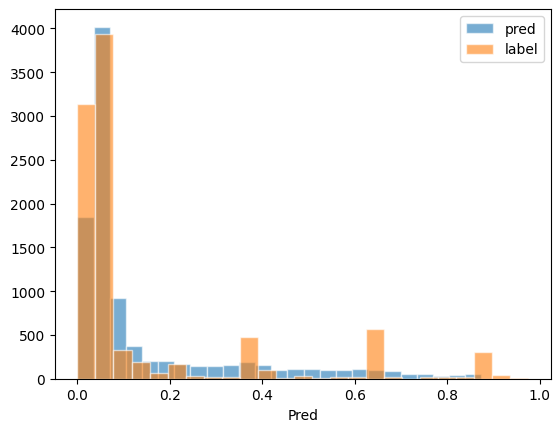

,Unnamed: 0,id,lat,lon,area,YMD,year,month,cover,depth_original,...,last_year_landsat_pred,pred,all_cat_pred,all_lgb_pred,svr_pred,linear_pred,ridge_pred,cat_pred,lgbm_pred,final_pred
0,3443,4236,26.757139,128.166861,20.0,20091002,2009.0,8.0,0.025,NaN,...,0.041550,0.011306,0.010738,0.022884,0.018046,0.046377,0.034502,0.039012,0.030765,0.028529
1,3535,4328,26.993018,127.910990,40.0,2009.10.1-2009.11.10,2009.0,8.0,0.600,NaN,...,0.168209,0.543650,0.431926,0.432488,0.482668,0.489147,0.491081,0.523095,0.542036,0.502882
2,3586,4379,26.995075,127.909460,40.0,2009.10.1-2009.11.10,2009.0,8.0,0.875,NaN,...,0.777524,0.793832,0.751061,0.686670,0.749570,0.745188,0.755696,0.767272,0.784807,0.758421
3,2963,3756,26.513139,127.861139,20.0,20090930.0,2009.0,8.0,0.025,NaN,...,0.006036,0.016835,0.265692,0.144248,0.062069,0.065662,0.099999,0.086816,0.113903,0.074443
4,3199,3992,26.993372,127.909152,40.0,2009.10.1-2009.11.10,2009.0,8.0,0.675,NaN,...,0.168209,0.649411,0.563615,0.573631,0.624757,0.627800,0.625005,0.619521,0.632623,0.622139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9565,7668,8461,24.400562,123.811336,1.5,2020.2.26,2019.0,12.0,0.000,0.30,...,0.280089,0.531748,0.501745,0.435805,0.579644,0.556283,0.552262,0.521924,0.519854,0.550784
9566,6760,7553,24.400279,123.815877,1.5,2020.2.26,2019.0,12.0,0.365,0.65,...,0.405313,0.355017,0.453993,0.356604,0.384859,0.369816,0.368545,0.387494,0.394552,0.386176
9567,4885,5678,24.399904,123.815796,1.5,2020.2.26,2019.0,12.0,0.495,0.58,...,0.580191,0.599547,0.369207,0.310296,0.577112,0.542702,0.545435,0.539421,0.537543,0.558267
9568,3489,4282,24.401309,123.811914,1.5,2020.2.26,2019.0,12.0,0.525,0.38,...,0.329148,0.427935,0.341028,0.240874,0.420881,0.387819,0.389510,0.372320,0.422488,0.396601


In [23]:
plt.hist(oof.final_pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

oof

In [24]:
pred_svr = np.mean(preds_svr, axis=1)
pred_ctb = np.mean(preds_ctb, axis=1)
pred_linear = np.mean(preds_linear, axis=1)
pred_ridge = np.mean(preds_ridge, axis=1)
pred_lgb = np.mean(preds_lgb, axis=1)

final_pred = (pred_svr + pred_ctb) / 2

pred_df["svr_pred"] = pred_svr
pred_df["ctb_pred"] = pred_ctb
pred_df["linear_pred"] = pred_linear
pred_df["ridge_pred"] = pred_ridge
pred_df["lgb_pred"] = pred_lgb
pred_df["final_pred"] = final_pred

pred_df = pred_df.sort_index()

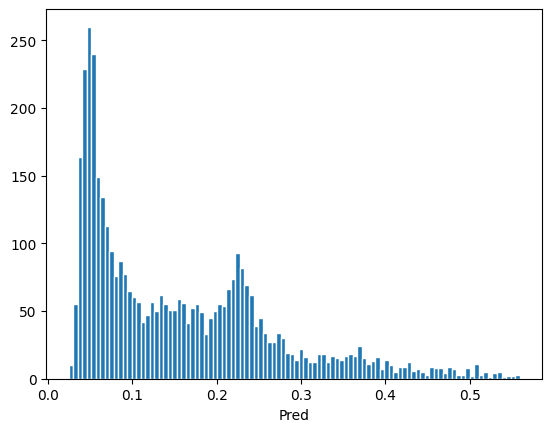

,Unnamed: 0,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,...,lgbm_pred,cat_pred,all_cat_pred,all_lgb_pred,svr_pred,ctb_pred,linear_pred,ridge_pred,lgb_pred,final_pred
0,0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,...,0.050385,0.055782,0.092336,0.008592,0.035489,0.035375,0.019985,0.024824,0.041168,0.035432
1,1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,...,0.065936,0.057143,0.126525,0.145920,0.063721,0.069906,0.084093,0.083514,0.087916,0.066813
2,2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,...,0.178579,0.092642,0.293431,0.253808,0.113087,0.156366,0.128882,0.140899,0.210841,0.134726
3,3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,...,0.040443,0.042862,0.080518,0.067678,0.037176,0.047037,0.043643,0.043869,0.050444,0.042106
4,4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,...,0.391534,0.361179,0.320846,0.420404,0.381071,0.408125,0.414374,0.408759,0.415146,0.394598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,...,0.217959,0.113559,0.142374,0.100437,0.113935,0.150532,0.105067,0.116506,0.173993,0.132233
4035,4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,...,0.066081,0.061082,0.087484,0.080391,0.056423,0.063361,0.062988,0.063317,0.067242,0.059892
4036,4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,...,0.210436,0.133324,0.363035,0.383679,0.170088,0.231550,0.209622,0.217130,0.237241,0.200819
4037,4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,...,0.167595,0.176071,0.142381,0.170099,0.172723,0.212546,0.184282,0.180257,0.215237,0.192635


In [25]:
pred_df["final_pred"] = pred_df["final_pred"].apply(lambda x: x if x>0 else 0)
pred_df["final_pred"] = pred_df["final_pred"].apply(lambda x: x if x<1 else cover_max)
pred_df[["final_pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_ENSEMBLE_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.final_pred,bins=100,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)

In [26]:
oof[["year","month","cat_pred","linear_pred","ridge_pred","svr_pred","final_pred","cover"]]

,year,month,cat_pred,linear_pred,ridge_pred,svr_pred,final_pred,cover
0,2009.0,8.0,0.039012,0.046377,0.034502,0.018046,0.028529,0.025
1,2009.0,8.0,0.523095,0.489147,0.491081,0.482668,0.502882,0.600
2,2009.0,8.0,0.767272,0.745188,0.755696,0.749570,0.758421,0.875
3,2009.0,8.0,0.086816,0.065662,0.099999,0.062069,0.074443,0.025
4,2009.0,8.0,0.619521,0.627800,0.625005,0.624757,0.622139,0.675
...,...,...,...,...,...,...,...,...
9565,2019.0,12.0,0.521924,0.556283,0.552262,0.579644,0.550784,0.000
9566,2019.0,12.0,0.387494,0.369816,0.368545,0.384859,0.386176,0.365
9567,2019.0,12.0,0.539421,0.542702,0.545435,0.577112,0.558267,0.495
9568,2019.0,12.0,0.372320,0.387819,0.389510,0.420881,0.396601,0.525


In [27]:
pred_df.groupby(["year","month"])["pred"].agg(["count","mean","std"])

count      mean       std
year   month                           
2002.0 7.0       84  0.167641  0.054060
       12.0      84  0.126883  0.055554
2004.0 2.0       41  0.171124  0.037130
2009.0 9.0       67  0.063777  0.022597
       10.0      43  0.041275  0.004718
       11.0     118  0.117832  0.094058
       12.0     178  0.077803  0.046860
2010.0 1.0       30  0.057883  0.017667
       3.0       15  0.118396  0.020947
       6.0      455  0.047552  0.008780
       7.0      545  0.095575  0.050004
       8.0      118  0.099539  0.054924
       10.0      95  0.098052  0.041731
       11.0      31  0.079188  0.023535
       12.0       8  0.055179  0.016303
2011.0 1.0       57  0.107041  0.038092
       3.0        3  0.092268  0.006444
       4.0      112  0.157637  0.086259
       7.0       15  0.039853  0.003259
       9.0      103  0.045792  0.004955
       10.0       8  0.061189  0.005796
2012.0 2.0       36  0.065753  0.006667
2013.0 9.0       19  0.422403  0.100417
2014.0 7.0       65  0.339090  0.092049
       9.0       21  0.316067  0.104612
       10.0      44  0.396660  0.091791
2019.0 9.0      584  0.161712  0.055958
       10.0    1060  0.289276  0.106821